In [123]:
import json
import math
from matplotlib import pyplot as plt
from pydantic import BaseModel, StrictBool, StrictInt, StrictStr, StrictFloat, ValidationError

In [124]:
class CameraData(BaseModel):
    hasLeft: StrictBool
    hasRight: StrictBool
    leftDistance: StrictInt
    rightDistance: StrictInt
    regionsCount: StrictInt
    regionsListSize: StrictStr
    unchangedLeft: StrictBool
    unchangedRight: StrictBool

class MotorData(BaseModel):
    leftSpeed: StrictInt
    rightSpeed: StrictInt

class Vec3(BaseModel):
    x: StrictInt
    y: StrictInt
    z: StrictInt

class SensorData(BaseModel):
    accel: Vec3
    gyro: Vec3
    mag: Vec3

class SteerData(BaseModel):
    angle: StrictFloat
    servoPosition: StrictInt

class Data(BaseModel):
    camera: CameraData
    mode: StrictInt
    motor: MotorData
    sensor: SensorData
    steer: SteerData
    timestamp: StrictInt

class Record(BaseModel):
    data: Data
    time: StrictInt

In [125]:
class DataPlotter:
    DATA_FOLDER = '../Data'

    def __init__(self, filename: str) -> None:
        self.data: list[Data]

        with open(f'{self.DATA_FOLDER}/{filename}') as fd:
            data = json.load(fd)
        try:
            self.data = [Record.model_validate(d).data for d in data]
        except ValidationError:
            self.data = [Data.model_validate(d) for d in data]
            
        a_k = 4
        g_k = 0.03125
        m_k = 1200
        g = 9.8
        a_max = 8191
        m_max = 32767

        self.left_speed = [d.motor.leftSpeed for d in self.data]
        self.right_speed = [d.motor.rightSpeed for d in self.data]
        self.servo_position = [d.steer.servoPosition for d in self.data]
        self.accel_x = [(d.sensor.accel.x / a_max) * a_k * g for d in self.data]
        self.accel_y = [(d.sensor.accel.y / a_max) * a_k * g for d in self.data]
        self.accel_z = [(d.sensor.accel.z / a_max) * a_k * g for d in self.data]
        self.mag_x = [d.sensor.mag.x * (m_k / m_max)  for d in self.data]
        self.mag_y = [d.sensor.mag.y * (m_k / m_max) for d in self.data]
        self.mag_z = [d.sensor.mag.z * (m_k / m_max) for d in self.data]
        self.gyro_x = [d.sensor.gyro.x * g_k * math.pi / 180 for d in self.data]
        self.gyro_y = [d.sensor.gyro.y * g_k * math.pi / 180 for d in self.data]
        self.gyro_z = [d.sensor.gyro.z * g_k * math.pi / 180 for d in self.data]

    def __len__(self) -> int:
        return len(self.data)

    def plot_all(self):
        _, axs = plt.subplots(4, 3, figsize=(15, 10))
        axs_flatten = axs.flatten()

        axs_flatten[0].plot(self.left_speed)
        axs_flatten[0].set_title('Left Speed')
        axs_flatten[1].plot(self.right_speed)
        axs_flatten[1].set_title('Right Speed')
        axs_flatten[2].plot(self.servo_position)
        axs_flatten[2].set_title('Servo Position')
        axs_flatten[3].plot(self.accel_x)
        axs_flatten[3].set_title('Accel X')
        axs_flatten[3].set_ylabel('m/s^2')
        axs_flatten[4].plot(self.accel_y)
        axs_flatten[4].set_title('Accel Y')
        axs_flatten[4].set_ylabel('m/s^2')
        axs_flatten[5].plot(self.accel_z)
        axs_flatten[5].set_title('Accel Z')
        axs_flatten[5].set_ylabel('m/s^2')
        axs_flatten[6].plot(self.gyro_x)
        axs_flatten[6].set_title('Gyro X')
        axs_flatten[6].set_ylabel('rad/s')
        axs_flatten[7].plot(self.gyro_y)
        axs_flatten[7].set_title('Gyro Y')
        axs_flatten[7].set_ylabel('rad/s')
        axs_flatten[8].plot(self.gyro_z)
        axs_flatten[8].set_title('Gyro Z')
        axs_flatten[8].set_ylabel('μT')
        axs_flatten[9].plot(self.mag_x)
        axs_flatten[9].set_title('Mag X')
        axs_flatten[9].set_ylabel('μT')
        axs_flatten[10].plot(self.mag_y)
        axs_flatten[10].set_title('Mag Y')
        axs_flatten[10].set_ylabel('μT')
        axs_flatten[11].plot(self.mag_z)
        axs_flatten[11].set_title('Mag Z')
        axs_flatten[11].set_ylabel('μT')
        
        for ax in axs_flatten:
            ax.set_xticklabels([])

        plt.tight_layout()
        plt.show()


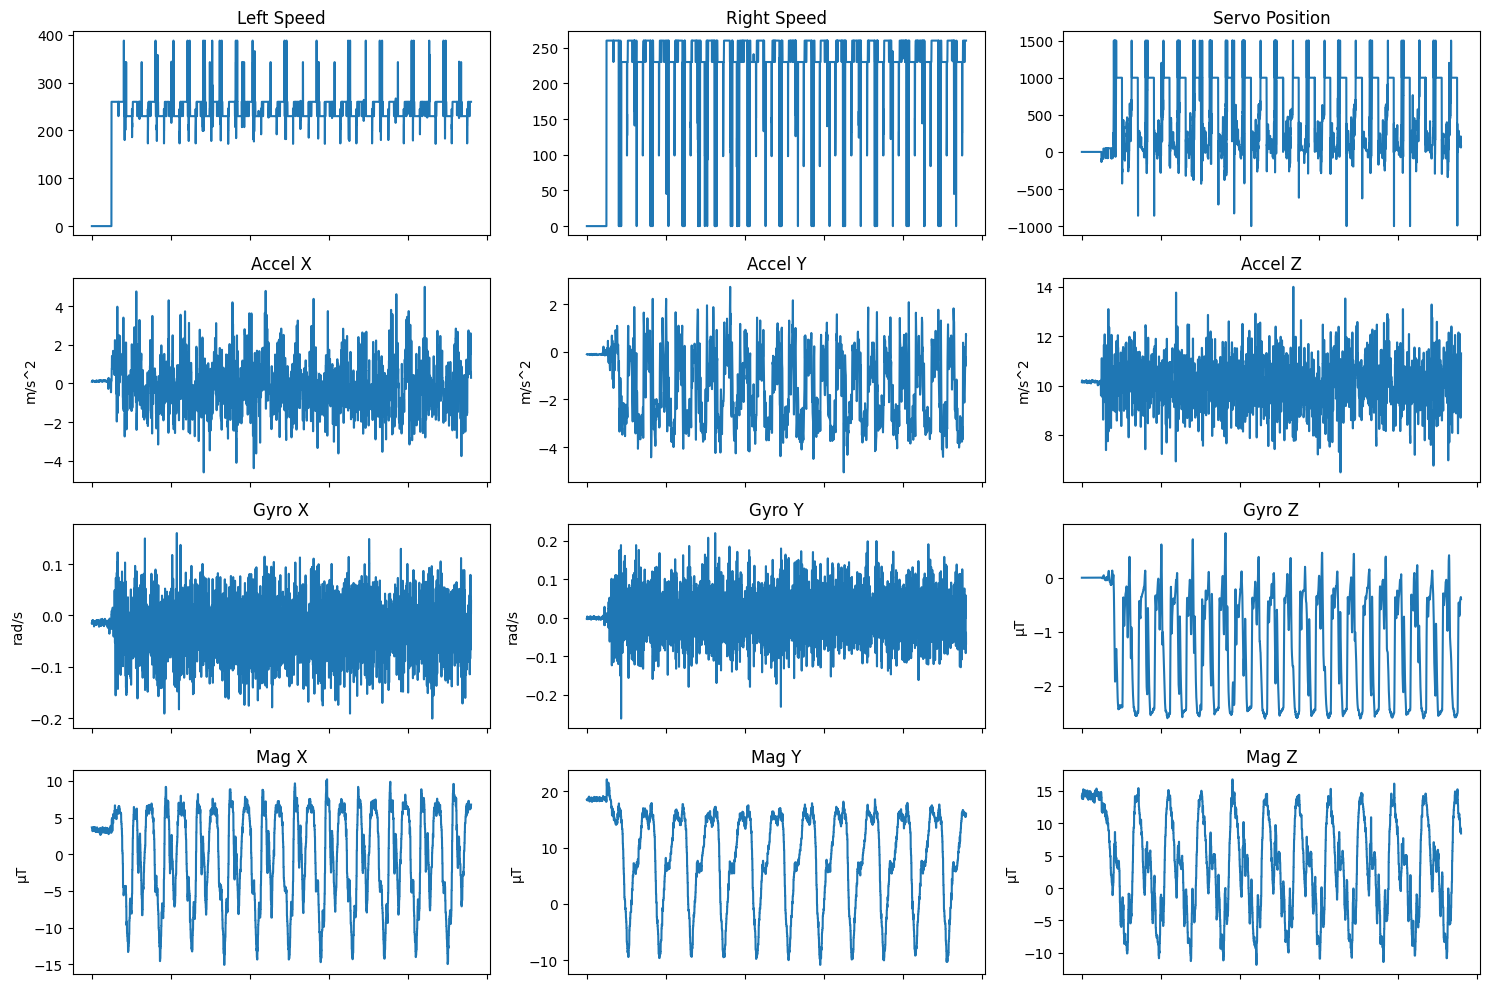

In [137]:
auto = DataPlotter('AutoData.json')
auto.plot_all()

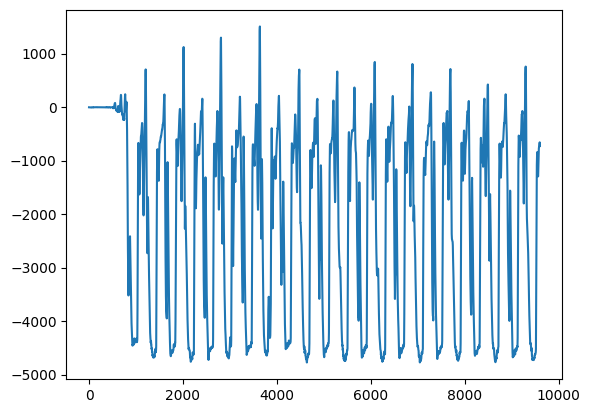

In [127]:
manual_data = DataPlotter('ManualData.json')
plt.plot([d.sensor.gyro.z for d in auto.data])

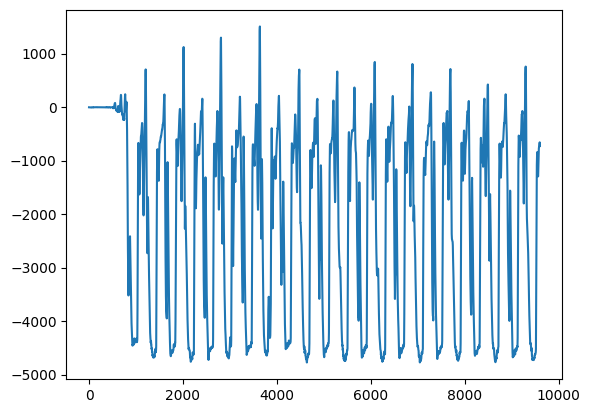

In [128]:
auto_ns = DataPlotter('AutoNoSensors.json')
plt.plot([d.sensor.gyro.z for d in auto.data])

In [129]:
def count_laps(data: list[Data], threshold: int) -> list[tuple[int, int]]:
    half_lap_detected = False
    lap_count = 0
    out = []

    for data_point in data:
        if data_point.sensor.gyro.z >= threshold and not half_lap_detected:
            # Rising edge detected
            out.append((lap_count, data_point.timestamp))
            half_lap_detected = True
        elif data_point.sensor.gyro.z <= -threshold and half_lap_detected:
            # Falling edge completes one full lap
            lap_count += 1
            half_lap_detected = False

    return out

def print_laps(laps: list[tuple[int, int]]) -> None:
    last_lap = laps[0][1]
    for i in range(1, len(laps)):
        print(f'Lap {laps[i][0]}: {laps[i][1] - last_lap} ms')
        last_lap = laps[i][1]
    average_time = sum([laps[i][1] - laps[i-1][1] for i in range(1, len(laps))]) / (len(laps) - 1)
    print(f'Average lap time: {average_time:.3f} ms')

In [130]:
auto_laps = count_laps(auto.data, 2)
print_laps(auto_laps)

Lap 1: 516 ms
Lap 2: 229 ms
Lap 3: 605 ms
Lap 4: 198 ms
Lap 5: 2412 ms
Lap 6: 2388 ms
Lap 7: 2448 ms
Lap 8: 2430 ms
Lap 9: 2322 ms
Lap 10: 2472 ms
Lap 11: 2142 ms
Lap 12: 354 ms
Lap 13: 2472 ms
Lap 14: 2556 ms
Lap 15: 2334 ms
Lap 16: 2100 ms
Lap 17: 420 ms
Lap 18: 2250 ms
Lap 19: 2154 ms
Lap 20: 402 ms
Lap 21: 2328 ms
Lap 22: 2174 ms
Lap 23: 304 ms
Lap 24: 2328 ms
Lap 25: 2520 ms
Lap 26: 2413 ms
Lap 27: 1973 ms
Lap 28: 428 ms
Lap 29: 2281 ms
Lap 30: 2535 ms
Average lap time: 1749.600 ms


In [131]:
manual_laps = count_laps(manual_data.data, 2)
print_laps(manual_laps)

Lap 1: 6624 ms
Lap 2: 5628 ms
Lap 3: 5808 ms
Lap 4: 2562 ms
Lap 5: 6522 ms
Lap 6: 2856 ms
Lap 7: 5970 ms
Lap 8: 5784 ms
Lap 9: 4333 ms
Lap 10: 608 ms
Lap 11: 886 ms
Lap 12: 455 ms
Lap 13: 98 ms
Average lap time: 3702.615 ms


In [133]:
auto_no_sensors_laps = count_laps(auto_ns.data, 2)
print_laps(auto_no_sensors_laps)

Lap 1: 444 ms
Lap 2: 582 ms
Lap 3: 2424 ms
Lap 4: 494 ms
Lap 5: 2584 ms
Lap 6: 2586 ms
Lap 7: 2232 ms
Lap 8: 402 ms
Lap 9: 2508 ms
Lap 10: 4782 ms
Lap 11: 415 ms
Lap 12: 2669 ms
Lap 13: 2490 ms
Lap 14: 2484 ms
Lap 15: 2604 ms
Lap 16: 2472 ms
Lap 17: 2664 ms
Lap 18: 5178 ms
Lap 19: 5124 ms
Lap 20: 2520 ms
Lap 21: 2712 ms
Lap 22: 2454 ms
Lap 23: 2250 ms
Lap 24: 486 ms
Lap 25: 2490 ms
Lap 26: 2630 ms
Lap 27: 5176 ms
Lap 28: 2574 ms
Lap 29: 2534 ms
Lap 30: 2520 ms
Lap 31: 2579 ms
Lap 32: 2453 ms
Lap 33: 2640 ms
Lap 34: 2493 ms
Average lap time: 2460.265 ms


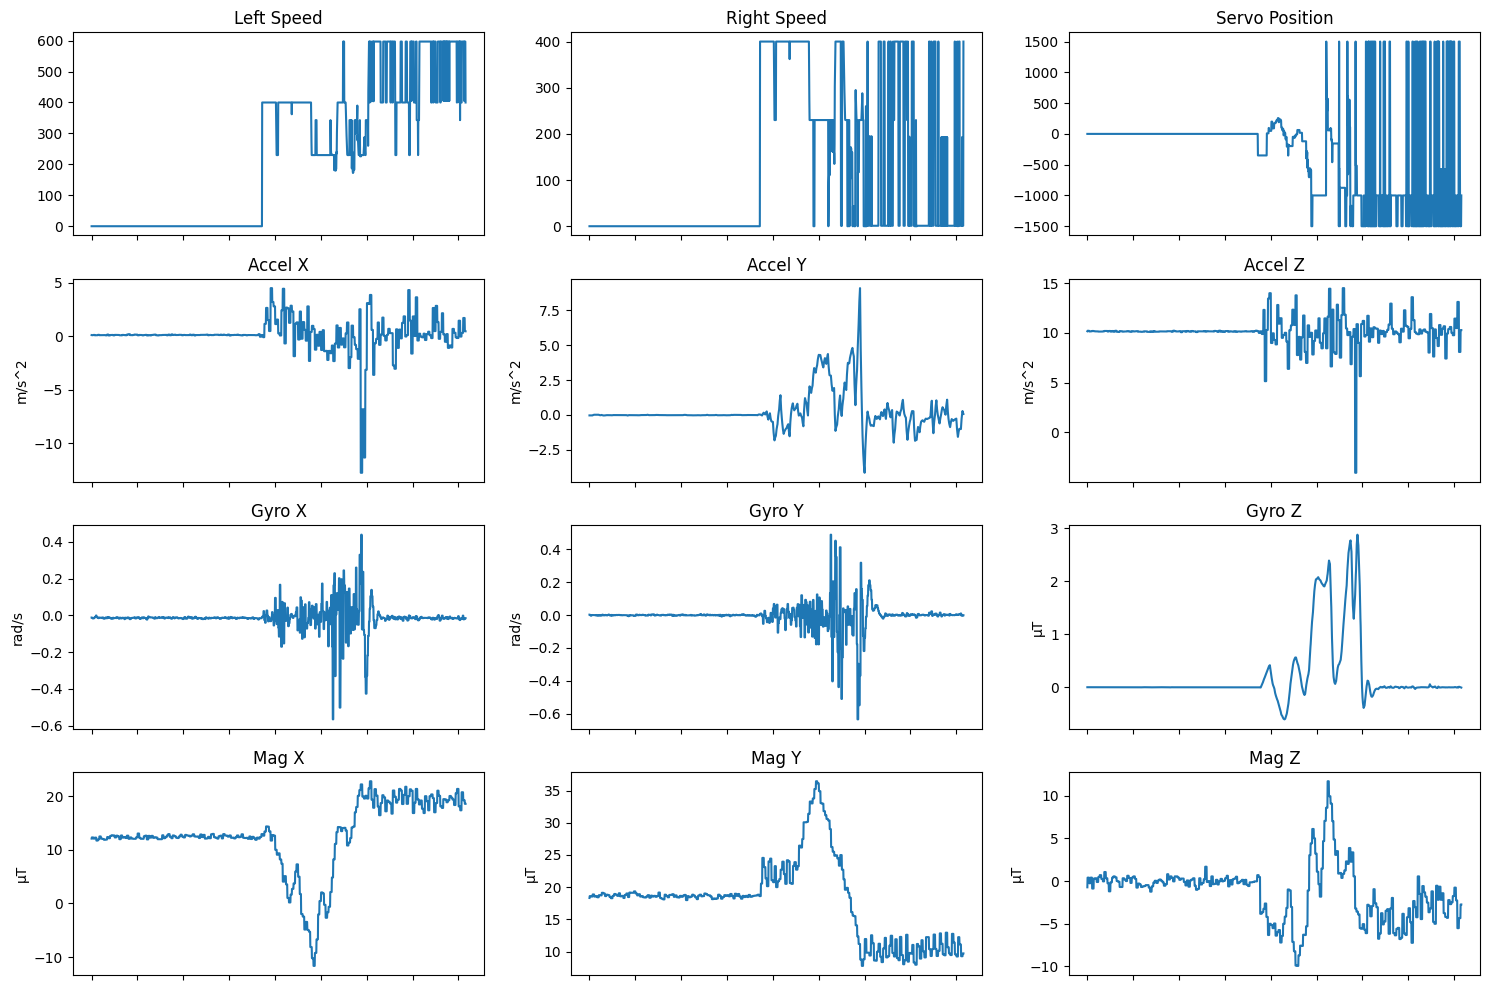

In [136]:
speed = DataPlotter('Speed.json')
speed.plot_all()